# Capstone Project
Author: Izzie Nielsen

### Data Importing
Importing data from Human vs. AI Generated Essays dataset

##### Steps:


*   Upload the the dataset to Colab
*   Ensure the unzip file name matches your file name
*   Unzip the file
*   Read the csv
*   Store essays and labels in a dataframe



Note: will also allow user input eventually

In [1]:
!unzip archive.zip

Archive:  archive.zip
  inflating: balanced_ai_human_prompts.csv  


In [2]:
import pandas as pd

df = pd.read_csv('/content/balanced_ai_human_prompts.csv')

display(df.head())
display(df.columns)

texts = df['text']

y = df['generated']

text  generated
0  Machine learning, a subset of artificial intel...          1
1  A decision tree, a prominent machine learning ...          1
2  Education, a cornerstone of societal progress,...          1
3  Computers, the backbone of modern technology, ...          1
4  Chess, a timeless game of strategy and intelle...          1

Index(['text', 'generated'], dtype='object')

### Tokenization and Text Pre-Processing

Preparing the text before inputing into the models. First, the data is split into test and training (80/20 split). Then the training and testing esssays (X) are tokenized by the BertTokenizer. SVM and BERT have different vectorization requirements.

For the BERT model:
* Save the training and testing tokens into a dataset
* Add attention mask to help the model ignore unimportant tokens
* Add labels to the dataset for supervised learning

For SVM:
* Use TF-IDF vectorization to assign values to the words
* Remove stop words




In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, random_state=42)


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
no_stops = [t for t in texts if t not in stopwords.words('english')]


## BERT Model Training

* Use transfer learning with pre-trained NLP model, BERT created by Google

In [12]:
#first tokenize, uses Bert Tokenizer
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_tokens = bert_tokenizer(X_train.tolist(), truncation=True, padding='max_length', max_length=1024, return_tensors='pt')
test_tokens = bert_tokenizer(X_test.tolist(), truncation=True, padding='max_length', max_length=1024, return_tensors='pt')


KeyboardInterrupt: 

In [ ]:
#take tokens from BertTokenizer and convert to dataset that BERT can use
#adds attention mask - which tokens to ignore
#dataset from HuggingFace
from datasets import Dataset

train_dataset = Dataset.from_dict({
    'input_ids': train_tokens['input_ids'],
    'attention_mask': train_tokens['attention_mask'],
    'labels': y_train.tolist()
})

test_dataset = Dataset.from_dict({
    'input_ids': test_tokens['input_ids'],
    'attention_mask': test_tokens['attention_mask'],
    'labels': y_test.tolist()
})

In [ ]:
from transformers import BertModel

model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

## SVM

1. Preprocessing
    
    * TF-IDF vectorization is used to allow the computer to understand the complex text data.

2. Model Creation

    * Create SVM model and train it using the vectorized training essays and labels for a supervised approach.
  
3. Evaulate Model Performance

    * Calculate accuracy, precision, and recall to determine performance

    * Generate Confusion Matrix

4. Evaluate for Overfitting


In [4]:
#takes tokens and assigns values
#only used by SVM
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=5000
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score

model = SVC(kernel='rbf', gamma = 'scale', C=1)
model.fit(X_train_tfidf, y_train)

SVC(C=1)

In [6]:
# grid search to determine the best hyper parameters
# ensures more generalization
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10],
              'gamma': ['scale', 'auto'],
              'kernel': ['rbf', 'linear']}

grid_search = GridSearchCV(model, param_grid, cv=5)

grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters:\n{grid_search.best_params_}")

best_model = grid_search.best_estimator_


Best parameters:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9963636363636363
Precision: 1.0
Recall: 0.9924812030075187


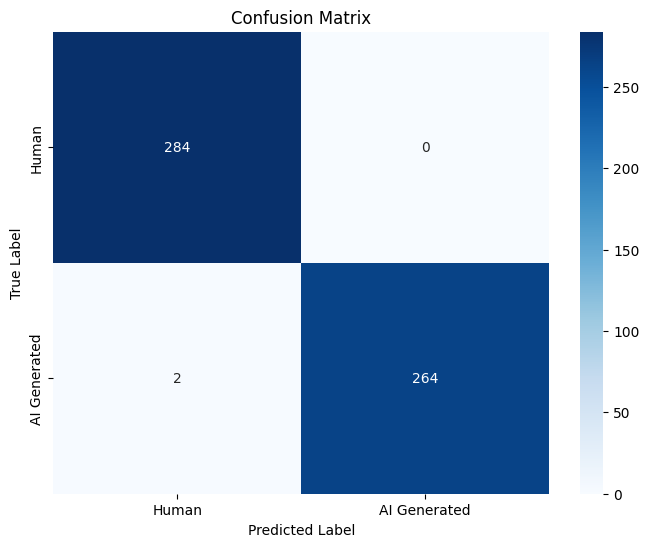

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI Generated'], yticklabels=['Human', 'AI Generated'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()